# Catastrophic forgetting during binary classification

In [24]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
# Set the seed for PyTorch
torch.manual_seed(42)

Adapted from Original Pytorch github https://github.com/pytorch/examples/blob/main/mnist/main.py 

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 2) # adapt to 2 classes [1 or 0]

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    

Train Epoch: 1 [0/172 (0%)]	Loss: 0.710694

Test set: Average loss: 0.0146, Accuracy: 25/43 (58%)

Epoch 1/14: Training Loss: 0.0116, Test Accuracy: 58.14%
Train Epoch: 2 [0/172 (0%)]	Loss: 0.718812

Test set: Average loss: 0.0146, Accuracy: 25/43 (58%)

Epoch 2/14: Training Loss: 0.0122, Test Accuracy: 58.14%
Train Epoch: 3 [0/172 (0%)]	Loss: 0.733826

Test set: Average loss: 0.0146, Accuracy: 25/43 (58%)

Epoch 3/14: Training Loss: 0.0120, Test Accuracy: 58.14%
Train Epoch: 4 [0/172 (0%)]	Loss: 0.692886

Test set: Average loss: 0.0146, Accuracy: 25/43 (58%)

Epoch 4/14: Training Loss: 0.0115, Test Accuracy: 58.14%
Train Epoch: 5 [0/172 (0%)]	Loss: 0.722565

Test set: Average loss: 0.0146, Accuracy: 25/43 (58%)

Epoch 5/14: Training Loss: 0.0120, Test Accuracy: 58.14%
Train Epoch: 6 [0/172 (0%)]	Loss: 0.741944

Test set: Average loss: 0.0146, Accuracy: 25/43 (58%)

Epoch 6/14: Training Loss: 0.0123, Test Accuracy: 58.14%
Train Epoch: 7 [0/172 (0%)]	Loss: 0.703187

Test set: Average lo

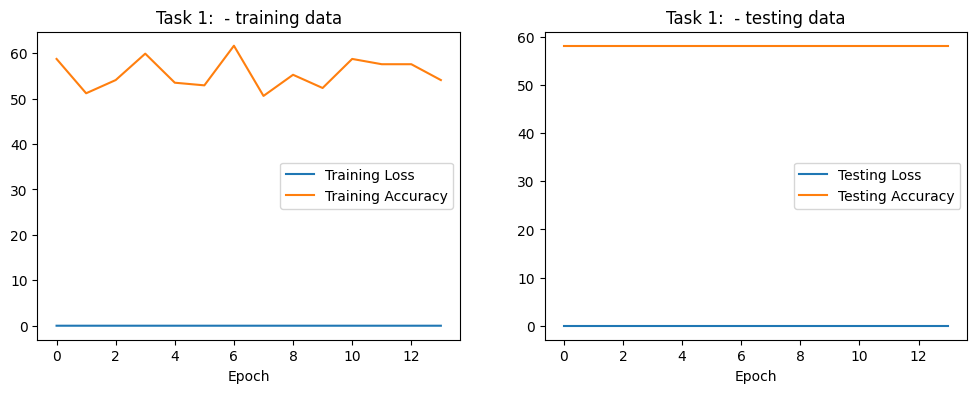

In [26]:

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0.0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        predicted_labels = torch.argmax(output, dim=1).float()
        # Activate gradients for backpropagation in the predictions
        predicted_labels.requires_grad = True 
        loss_BCE = nn.BCEWithLogitsLoss()
        loss = loss_BCE(predicted_labels, target.float())
        total_loss += loss.item()
        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()


        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    # Calculate and return the average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100.*correct / len(train_loader.dataset)
    return accuracy, average_loss
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            predicted_labels = torch.argmax(output, dim=1).float()#.squeeze(1)
            # Set requires_grad to True
            predicted_labels.requires_grad = True
            loss_BCE = nn.BCEWithLogitsLoss()
            test_loss += loss_BCE(predicted_labels, target.float()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return accuracy, test_loss

def train_and_test(args, model, device, train_loader, test_loader, optimizer, scheduler, title = ""):
    train_losses = []  # Store training losses
    test_accuracies = []  # Store test accuracies
    test_losses = [] 
    train_accuracies = [] 

    for epoch in range(1, args.epochs + 1):
        train_accuracy, train_loss = train(args, model, device, train_loader, optimizer, epoch)
        test_accuracy, test_loss = test(model, device, test_loader)
        scheduler.step()

        
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

            # Print training loss and test accuracy during each epoch
        print(f'Epoch {epoch}/{args.epochs}: Training Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        
    # Plot loss and accuracy after all epochs
    plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title)

def save_model_state_dict(model_state_dict, filename, overwrite=True):
    models_folder = "models"
    
    # Check if the models folder exists, if not, create it
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    file_path = os.path.join(models_folder, filename)

    # Check if the file already exists
    if os.path.exists(file_path) and not overwrite:
        user_input = input(f"The file '{filename}' already exists. Do you want to overwrite it? (yes/no): ")
        if user_input.lower() != 'yes':
            print("Model not saved.")
            return

    # Save the model state dict
    torch.save(model_state_dict, file_path)
    print(f"Model state dict saved to: {file_path}")
def plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title = ""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Training Loss and Accuracy
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{title} - training data')
    ax1.legend()

    # Plot Testing Loss and Accuracy
    ax2.plot(test_losses, label='Testing Loss')
    ax2.plot(test_accuracies, label='Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - testing data')
    ax2.legend()
def plot_loss_and_accuracy_single(test_accuracies, test_losses, title = ""):
    fig, (ax2) = plt.subplots(1, 1, figsize=(12, 4))
    # Plot Testing Loss and Accuracy
    ax2.plot(test_losses, label='Testing Loss')
    ax2.plot(test_accuracies, label='Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - testing data')
    ax2.legend()

    
def get_data_loaders(dataset, train_size, test_size, train_kwargs, test_kwargs):
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, **train_kwargs)
    test_loader = DataLoader(test_set, **test_kwargs)
    return train_loader, test_loader


parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
parser.add_argument('--test_reduced', action='store_true', default=True,
                        help='For Saving the current Model')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()
    
torch.manual_seed(args.seed)

if use_cuda:
        device = torch.device("cuda")
elif use_mps:
        device = torch.device("mps")
else:
        device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}

if 'cuda' in str(device):
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:1000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)

# Define task 1 labeling
task1_classes = [1,0]
# Define task 2 labeling
task2_classes = [5,0]

task1_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task1_classes]
task2_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task2_classes]

task1_dataset = Subset(mnist_dataset, task1_indices)
task2_dataset = Subset(mnist_dataset, task2_indices)

train_size_task1 = int(0.8 * len(task1_indices))
test_size_task1 = len(task1_indices) - train_size_task1

train_size_task2 = int(0.8 * len(task2_indices))
test_size_task2 = len(task2_indices) - train_size_task2

train_loader_task1, test_loader_task1 = get_data_loaders(task1_dataset, train_size_task1, test_size_task1,
                                                             train_kwargs, test_kwargs)
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
train_and_test(args, model, device, train_loader_task1, test_loader_task1, optimizer, scheduler,title="Task 1: ")
model_state_dict_task1 = model.state_dict()
save_model_state_dict(model_state_dict_task1, "mnist_cnn_task1.pt")

Test model trained on task 1 over testing data

In [27]:
test(model, device, test_loader_task1)


Test set: Average loss: 0.0146, Accuracy: 25/43 (58%)



(58.13953488372093, 0.014605989289838214)

Finetune model, trained on task 1 with new labels of task 2


-------------------MODEL TRAINING TASK #2-------------------
Train Epoch: 1 [0/140 (0%)]	Loss: -0.236496

Test set: Average loss: 0.0055, Accuracy: 19/35 (54%)

Epoch 1/14: Training Loss: 0.0030, Test Accuracy: 54.29%
Train Epoch: 2 [0/140 (0%)]	Loss: 0.154740

Test set: Average loss: 0.0055, Accuracy: 19/35 (54%)

Epoch 2/14: Training Loss: 0.0054, Test Accuracy: 54.29%
Train Epoch: 3 [0/140 (0%)]	Loss: 0.144440

Test set: Average loss: 0.0055, Accuracy: 19/35 (54%)

Epoch 3/14: Training Loss: 0.0085, Test Accuracy: 54.29%
Train Epoch: 4 [0/140 (0%)]	Loss: 0.037247

Test set: Average loss: 0.0055, Accuracy: 19/35 (54%)

Epoch 4/14: Training Loss: 0.0049, Test Accuracy: 54.29%
Train Epoch: 5 [0/140 (0%)]	Loss: 0.027558

Test set: Average loss: 0.0055, Accuracy: 19/35 (54%)

Epoch 5/14: Training Loss: 0.0036, Test Accuracy: 54.29%
Train Epoch: 6 [0/140 (0%)]	Loss: -0.031188

Test set: Average loss: 0.0055, Accuracy: 19/35 (54%)

Epoch 6/14: Training Loss: 0.0020, Test Accuracy: 54.29%
T

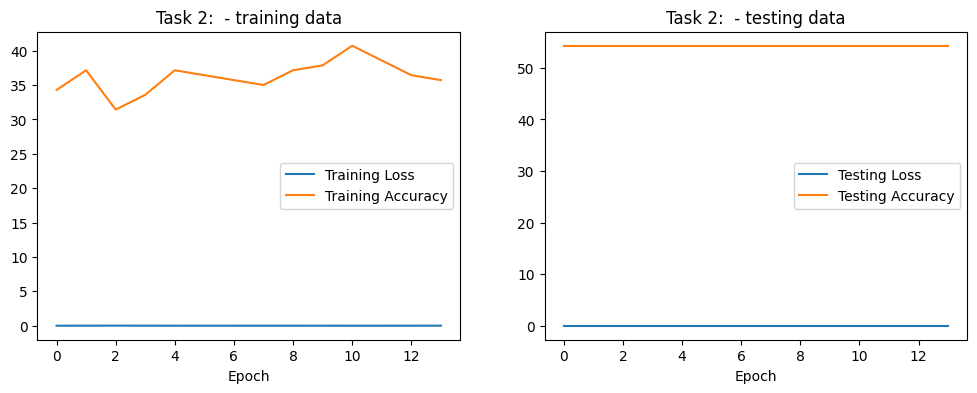

In [28]:
model_task2 = Net().to(device)
model_task2.load_state_dict(model_state_dict_task1.copy()) 
optimizer_task2 = optim.Adadelta(model_task2.parameters(), lr=args.lr)
scheduler_task2 = StepLR(optimizer_task2, step_size=1, gamma=args.gamma)

print(f"MODEL TRAINING TASK #2".center(60, "-"))

train_loader_task2, test_loader_task2 = get_data_loaders(task2_dataset, train_size_task2, test_size_task2,
                                                             train_kwargs, test_kwargs)

train_and_test(args, model_task2, device, train_loader_task2, test_loader_task2, optimizer_task2, scheduler_task2, title="Task 2: ")

model_state_dict_task2 = model_task2.state_dict()
save_model_state_dict(model_state_dict_task1, "mnist_cnn_task2.pt")


Test model finetuned in task 2 over second data

In [29]:
test(model_task2, device, test_loader_task2)


Test set: Average loss: 0.0055, Accuracy: 19/35 (54%)



(54.285714285714285, 0.005502538595880781)

## Testing model again on task 1


In [31]:
model_task1_adapted = Net().to(device)
model_task1_adapted.load_state_dict(model_state_dict_task2.copy()) 
optimizer_task1_adapted = optim.Adadelta(model_task1_adapted.parameters(), lr=args.lr)
scheduler_taskadapted = StepLR(optimizer_task1_adapted, step_size=1, gamma=args.gamma)
train_loader_task1_adapted, test_loader_task1_adapted = get_data_loaders(task1_dataset, train_size_task1, test_size_task1,
                                                             train_kwargs, test_kwargs)
test(model_task1_adapted, device, test_loader_task1_adapted)


Test set: Average loss: 0.0160, Accuracy: 20/43 (47%)



(46.51162790697674, 0.016023032887037412)